Здесь я разделить признаки на номинальные, порядовые и числовые. Заменил отсутствующие значения и присвоил тип каждой переменной.

In [64]:
%reload_ext autoreload
%autoreload 2

In [65]:
import sys; sys.path.append('scripts')
from common import *
from global_common import *

In [66]:
# Читаем данные
path_to_data = Path('../data')
train_df = pd.read_csv(path_to_data/'train_music.csv')
train_y = train_df['target']
del train_df['target']

test_df  = pd.read_csv(path_to_data/'test_music.csv')

sample_submission_df = pd.read_csv(path_to_data/'sample_submission_music.csv')
print(f'Shape of train {train_df.shape}\nShape of test {test_df.shape}\n')

Shape of train (70000, 460)
Shape of test (30000, 460)



In [12]:
# # Посмотреть кол-во пропущенных значений по переменным
# data_na = train_df.isnull().sum().values / train_df.shape[0] *100
# df_na = pd.DataFrame(data_na, index=train_df.columns, columns=['Count'])
# df_na = df_na.sort_values(by=['Count'], ascending=False)

# missing_value_count = df_na[df_na['Count']>0].shape[0]

# print(f'We got {missing_value_count} rows which have missing value in train set ')
# df_na.head(4)

In [ ]:
# # Raw data
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')
# test['Target'] = np.nan

# data = train.append(test, sort = True)

In [67]:
# Объединяем выборки для обработки переменных, запоминаем индексы чтобы потом разделить назад
train_idx = train_df.index[-1]
merged = pd.concat([train_df, test_df], axis=0, )

# целочисленные переменные----------------------
int_columns = [o for o in train_df.columns for crit in ['flag', 'is', 'count'] if crit in o]
int_columns += ['sim_count', 'device_type', 'manufacturer_category', 'os_category', 'tp_flag', 
                'days_exp', 'paym_last_days']
print(f'Целочисленных переменных  : {len(int_columns)}')

# Если в значениях переменной есть 0, тогда пропуски заполняет -1. Если нет 0, тогда заполняем нулем.
merged[int_columns] = merged[int_columns].apply(lambda x: x.fillna(-1) if 0 in x.values else x.fillna(0))
merged[int_columns] = merged[int_columns].apply(lambda x: x.astype('int'))
print('Целочисленные переменные обработаны.')

Целочисленных переменных  : 236
Целочисленные переменные обработаны.


In [73]:
# # отдельно выделяем бинарные в тип bool
# bool_columns = [o for o in train_df.columns for crit in ['flag', 'is'] if crit in o]
# merged[bool_columns] = merged[bool_columns].apply(lambda x: x.astype('bool'))

In [69]:
# с плавающей точкой переменные----------------------
float_cols = [o for o in train_df.columns for crit in ['data_type', 'rr', 'vol', 'cost', 'dur', 
                                                       'sum', 'part', 'clc', 'lt', 'brnd'] if crit in o]
print(f'Переменных с плавающей точкой : {len(float_cols)}')

merged[float_cols] = merged[float_cols].apply(lambda x: x.fillna(x.median()) if 0 in x.values else x.fillna(0))
merged[float_cols] = merged[float_cols].apply(lambda x: x.astype('float'))
print('Переменных с плавающей точкой обработаны.')

Переменных с плавающей точкой : 225
Переменных с плавающей точкой обработаны.


In [70]:
# Проверить что нет остаточных переменных. 1 это строк переменная id.
x = set(int_columns + float_cols)
d = set(train_df.columns)
remain_cols = list(d.difference(x))
len(remain_cols)

1

In [51]:
# # Нужно выделить категориальные переменные для алгоритма
# cat_names = ['sim_count', 'device_type', 'manufacturer_category', 'os_category', 'tp_flag', 
#             ] # , 'days_exp', 'paym_last_days', 'inact_days_count', 

In [71]:
# Разделяем обработанные обучающую и тестовую выборки
train = merged.iloc[:train_idx+1, :]
train['target'] = train_y
test = merged.iloc[train_idx+1:, :]
del merged
del train_y

In [58]:
# to_drop = ['count_act_type_5', 'count_act_type_7', 'count_gift_type_2', 'paym_sum_m1', 'paym_sum_m2', 
#            'rr_gift_type_2', 'service_2_flag', 'sms_roam_in_count_m1', 'sms_roam_in_count_m2', 'sms_roam_in_count_m3', 
#            'voice_omo_cc_count_m2', 'voice_omo_cc_count_m3', 'voice_onnet_cc_count_m1', 'voice_onnet_cc_count_m2', 
#            'voice_onnet_cc_count_m3', 'voice_onnet_in_count_m1', 'voice_onnet_in_count_m2', 'voice_onnet_in_count_m3', 
#            'voice_onnet_in_dur_m1', 'voice_onnet_in_dur_m2', 'voice_onnet_in_dur_m3', 'voice_onnet_out_count_m1', 
#            'voice_onnet_out_count_m2', 'voice_onnet_out_count_m3', 'voice_onnet_out_dur_m1', 'voice_onnet_out_dur_m2', 
#            'voice_onnet_out_dur_m3', 'voice_pstn_out_dur_m1']

# train.drop(columns= to_drop, inplace=True)
# test.drop(columns= to_drop, inplace=True)

In [72]:
# Prepare dataset for training
cols_to_drop = [
    'id',
    'target',
]

categorical = cat_names

X = train.drop(cols_to_drop, axis=1, errors='ignore')
y = train.target.values

id_test = test.id.values
X_test = test.drop(cols_to_drop[0], axis=1, errors='ignore')


print('train.shape = {}, test.shape = {}'.format(train.shape, test.shape))

lgb_params = {
    'num_leaves' : 16,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 5,
    'learning_rate': 0.01, 
    'verbose': -1,
    'num_threads': 8,
#     'scale_pos_weight' : int(train.target.mean()*10),
    'is_unbalance' : 'true',
}

# Build the model
cnt = 0
p_buf = []
n_splits = 7
n_repeats = 1
kf = StratifiedKFold(
    n_splits=n_splits, 
    )
err_buf = []   

n_features = X.shape[1]

for train_index, valid_index in kf.split(X, y):
    print('Fold {}/{}*{}'.format(cnt + 1, n_splits, n_repeats))
    params = lgb_params.copy() 
    
    lgb_train = lgb.Dataset(
        X.iloc[train_index], 
        y[train_index], 
#         categorical_feature=categorical,
    
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X.iloc[valid_index], 
        y[valid_index],
#         categorical_feature=categorical,
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=100000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=200, 
        verbose_eval=100,
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break

        del importance, model_fnames, tuples

    p = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
    err = roc_auc_score(y[valid_index], p)

    print('{} auc: {}'.format(cnt + 1, err))

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)
    err_buf.append(err)


    cnt += 1

    del model, lgb_train, lgb_valid, p
    gc.collect

err_mean = np.mean(err_buf)
err_std = np.std(err_buf)
print('auc = {:.6f} +/- {:.6f}'.format(err_mean, err_std))

preds = p_buf/cnt

train.shape = (70000, 461), test.shape = (30000, 460)
Fold 1/7*1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.818861	valid_1's auc: 0.79522
[200]	training's auc: 0.830942	valid_1's auc: 0.802227
[300]	training's auc: 0.842337	valid_1's auc: 0.808826
[400]	training's auc: 0.851999	valid_1's auc: 0.81327
[500]	training's auc: 0.86018	valid_1's auc: 0.816799
[600]	training's auc: 0.867471	valid_1's auc: 0.819594
[700]	training's auc: 0.873699	valid_1's auc: 0.820937
[800]	training's auc: 0.879247	valid_1's auc: 0.822213
[900]	training's auc: 0.884269	valid_1's auc: 0.823307
[1000]	training's auc: 0.888622	valid_1's auc: 0.823827
[1100]	training's auc: 0.892678	valid_1's auc: 0.82423
[1200]	training's auc: 0.896613	valid_1's auc: 0.824483
[1300]	training's auc: 0.90025	valid_1's auc: 0.824811
[1400]	training's auc: 0.903949	valid_1's auc: 0.825049
[1500]	training's auc: 0.907498	valid_1's auc: 0.824915
[1600]	training's auc: 0.910801	valid_1's auc:

[800]	training's auc: 0.878258	valid_1's auc: 0.821014
[900]	training's auc: 0.883461	valid_1's auc: 0.821531
[1000]	training's auc: 0.887951	valid_1's auc: 0.821595
[1100]	training's auc: 0.892341	valid_1's auc: 0.822049
[1200]	training's auc: 0.896577	valid_1's auc: 0.822624
[1300]	training's auc: 0.9006	valid_1's auc: 0.82305
[1400]	training's auc: 0.904209	valid_1's auc: 0.823118
[1500]	training's auc: 0.907715	valid_1's auc: 0.823246
[1600]	training's auc: 0.911062	valid_1's auc: 0.823098
Early stopping, best iteration is:
[1481]	training's auc: 0.907054	valid_1's auc: 0.82329
7 auc: 0.823290206074903
auc = 0.826419 +/- 0.007008


In [ ]:
# p_8284

In [55]:
# Prepare submission
subm = pd.DataFrame()
subm['id'] = test_df.id.values
subm['prediction'] = p
subm.to_csv('submissions/with_auto_merge.csv', index=False)

# Old

In [ ]:
# Объединяем выборки для обработки переменных, запоминаем индексы чтобы потом разделить назад
train_idx = train_df.index[-1]
merged = pd.concat([train_df, test_df], axis=0)

Так как для замещения пропусков нужно понимать что использовать медиану или -1. В категориальных признаках мы используем -1. В численных мы используем медиану.

Также нужно разделить признакми на три категории: бинарные (их просто оставляем и нигде не указываем), категориальные - это те признаки которые мы хотим закодировать в эмбединги и числовые признаки - это те которые нужно просто нормализовать.

In [ ]:
# Бинарный признка целочисленное значение, пропуски = -1, не эмбединги
binary_columns = [o for o in merged.columns if 'flag' in o or 'is' in o]
binary_columns.remove('tp_flag')
print(f'Бинарных признаков - {len(binary_columns)}')

# Для категориальных признаков используем -1. Кодируем в эмбединги. Целочисленные значения.
cat_names = ['sim_count', 'device_type', 'manufacturer_category', 'os_category', 'tp_flag']
print(f'Категориальных признаков - {len(cat_names)}')

# Флоат должны использовать медиану для замещения пропусков
float_columns = list(set(merged.columns).difference(set(binary_columns+cat_names)))
float_columns.remove('id')
print(f'Числовых признаков - {len(float_columns)}')

In [28]:
# Замещаем пропущенные значения в соответствии с типом данных
merged[binary_columns] = merged[binary_columns].apply(lambda x: x.fillna(-1))
merged[cat_names] = merged[cat_names].apply(lambda x: x.fillna(-1))
merged[float_columns] = merged[float_columns].apply(lambda x: x.fillna(x.median()))
assert merged.isna().sum().sum() == 0, 'Buddy, slow down!'

# Присваивает тип для каждой из переменных
merged[binary_columns] = merged[binary_columns].apply(lambda x: x.astype('int'))
merged[cat_names] = merged[cat_names].apply(lambda x: x.astype('int'))
merged[float_columns] = merged[float_columns].apply(lambda x: x.astype('float'))

In [29]:
# Разделяем обработанные обучающую и тестовую выборки
train_df_proc = merged.iloc[:train_idx+1, :]
train_df_proc['target'] = train_y
test_df_proc = merged.iloc[train_idx+1:, :]
del merged
del train_y

# Указываем для модели категориальные (для кодировки в эмб) и числовые
dep_var = 'target'
cont_names = float_columns
cat_names = cat_names
procs = [Categorify, Normalize]

In [13]:
# Создаем инстанс метрики ROC-AUC
roc_auc = RocAuc(roc_auc_score)

In [32]:
# # Колонку id не использовать в обучении
# cols = train_df_proc.columns[1:]

In [14]:
# Оборачивае тестовый файл в обертку fast.ai
test = TabularList.from_df(test, 
                           path=path_to_data, 
                           cat_names=cat_names,
                           cont_names=cont_names)

In [15]:
_, valid_x, _, _ = train_test_split(train.index, 
                                    train['target'].values, 
                                    stratify=train['target'].values,
                                    test_size=0.2, 
                                    random_state=SEED)

In [16]:
data = (TabularList.from_df(train, path=path_to_data, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(valid_x.values))
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch())
data.batch_size = 128

In [17]:
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, roc_auc])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


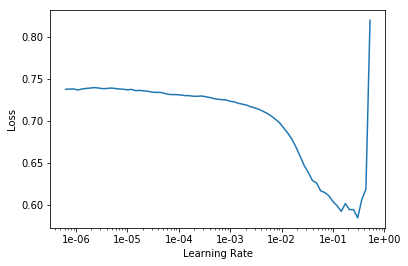

In [18]:
learn.lr_find()
learn.recorder.plot()

In [20]:
# learn.fit_one_cycle(4, 2e-2)

In [74]:
# Валидация
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
roc_auc_score(valid_preds[1], valid_preds[0][:, 1].tolist()) 

0.757943522049218

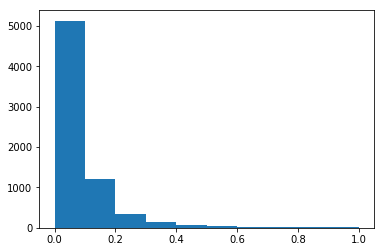

In [77]:
plt.hist(valid_preds[0][:, 1].tolist());

In [78]:
test_preds = learn.get_preds(ds_type=DatasetType.Test)
plt.hist(test_preds[0][:, 1].tolist());

In [59]:
make_submition(test_df, learn, 'third_try')

File saved.
